In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load Data
data = pd.read_csv('first inten project.csv')

In [3]:
# print first 5 rows
data.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [4]:
# Convert 'date of reservation' to datetime
data['Date of reservation'] = pd.to_datetime(data['date of reservation'], errors='coerce')


In [5]:
# Drop rows where 'Date of reservation' is null
data.dropna(subset=['Date of reservation'], inplace=True)

In [6]:
# Drop original 'date of reservation' column
data.drop('date of reservation', axis=1, inplace=True)

In [7]:
# Extract date features
data['reservation_year'] = data['Date of reservation'].dt.year
data['reservation_month'] = data['Date of reservation'].dt.month
data['reservation_dayofweek'] = data['Date of reservation'].dt.dayofweek

In [8]:
# Drop 'Date of reservation' column 
data.drop('Date of reservation', axis=1, inplace=True)

In [9]:
data.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,booking status,reservation_year,reservation_month,reservation_dayofweek
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,Not_Canceled,2015,10,4
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,Not_Canceled,2018,11,1
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,Canceled,2018,2,2
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,Canceled,2017,5,5
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,Canceled,2018,4,2


In [10]:
# Handle Missing Values and Whitespace in Categorical Columns
categorical_columns = data.select_dtypes(include=['object']).columns

In [11]:
# Check for whitespace in each categorical column
for col in categorical_columns:
    if data[col].apply(lambda x: isinstance(x, str) and x.strip() != x).any():
        print(f"Column '{col}' has whitespace issues.")
    else:
        print(f"column '{col}' has no whitespace issues.")

column 'Booking_ID' has no whitespace issues.
column 'type of meal' has no whitespace issues.
column 'room type' has no whitespace issues.
column 'market segment type' has no whitespace issues.
column 'booking status' has no whitespace issues.


In [12]:
# check missing values in the dataset
missing_values = data.isna().sum()
print(f"Missing values per column:\n{missing_values}")

Missing values per column:
Booking_ID                  0
number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
booking status              0
reservation_year            0
reservation_month           0
reservation_dayofweek       0
dtype: int64


In [13]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36248 entries, 0 to 36284
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36248 non-null  object 
 1   number of adults          36248 non-null  int64  
 2   number of children        36248 non-null  int64  
 3   number of weekend nights  36248 non-null  int64  
 4   number of week nights     36248 non-null  int64  
 5   type of meal              36248 non-null  object 
 6   car parking space         36248 non-null  int64  
 7   room type                 36248 non-null  object 
 8   lead time                 36248 non-null  int64  
 9   market segment type       36248 non-null  object 
 10  repeated                  36248 non-null  int64  
 11  P-C                       36248 non-null  int64  
 12  P-not-C                   36248 non-null  int64  
 13  average price             36248 non-null  float64
 14  specia

In [14]:
# Outlier Detection and Removal (Using IQR Method)
columns_to_check = ['average price ', 'lead time']

In [15]:
# detect outliers using IQR and return the count of outliers
def count_outliers_iqr(df, columns):
    outlier_counts = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count the number of outliers
        outlier_count = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
        outlier_counts[col] = outlier_count
    
    return outlier_counts

In [16]:
# Get the count of outliers for 'Average price' and 'Lead time'
outlier_counts = count_outliers_iqr(data, columns_to_check)

In [17]:
# Print the number of outliers in each column
for col, count in outlier_counts.items():
    print(f"Number of outliers in '{col}': {count}")

Number of outliers in 'average price ': 1692
Number of outliers in 'lead time': 1332


In [18]:
# remove outliers using IQR
def remove_outliers_iqr(df, columns):
    outlier_counts = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        

        
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
    return df

In [19]:
# Remove outliers from 'Average price' and 'Lead time'
data_cleaned = remove_outliers_iqr(data, columns_to_check)

In [20]:
# Check dataset shape after removing outliers
print(f"Shape of the dataset after removing outliers: {data_cleaned.shape}")

Shape of the dataset after removing outliers: (33438, 19)


In [21]:
# Step 6: One-hot Encoding for Categorical Columns
data_cleaned = pd.get_dummies(data_cleaned, columns=['type of meal', 'room type', 'market segment type'], drop_first=True)


In [22]:
# Check the new shape after one-hot encoding
print(f"Shape of the dataset after one-hot encoding: {data_cleaned.shape}")

Shape of the dataset after one-hot encoding: (33438, 28)


In [23]:
# Step 7: Feature Selection and Target Definition
features = [
    'number of adults', 
    'number of children', 
    'number of weekend nights', 
    'number of week nights', 
    'lead time', 
    'average price ', 
    'special requests', 
    'car parking space', 
    'reservation_month',       
    'reservation_dayofweek',
    'reservation_year'
]
target = 'booking status'

In [24]:
X = data_cleaned[features]
y = data_cleaned[target].map({'Not_Canceled': 1, 'Canceled': 0}) 

In [25]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
#  Modeling with Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [27]:
# Fit the model to the training data
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [28]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

In [29]:
# Step 11: Accuracy Calculation and Model Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of the Random Forest model: {accuracy_rf:.2f}")

Accuracy of the Random Forest model: 0.88


In [30]:
# Classification report for detailed metrics
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      2067
           1       0.89      0.94      0.92      4621

    accuracy                           0.88      6688
   macro avg       0.87      0.85      0.86      6688
weighted avg       0.88      0.88      0.88      6688



In [31]:
importance = rf_model.feature_importances_

In [32]:
feature_names = X.columns

In [33]:
# Sort the features by importance
indices = np.argsort(importance)[::-1]

In [34]:
# Print feature names and their importance scores
print("Feature Importances:")
for i in indices:
    print(f"{feature_names[i]}: {importance[i]}")

Feature Importances:
lead time: 0.3552905765880269
average price : 0.2280430898737006
reservation_month: 0.10247876538549258
special requests: 0.08791253250125218
number of week nights: 0.05784269203239277
reservation_dayofweek: 0.05617703145204252
number of weekend nights: 0.03820627846590876
number of adults: 0.02993972454816838
reservation_year: 0.028000592576309633
number of children: 0.010033033784621717
car parking space: 0.0060756827920839425


In [35]:
# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest:")
print(conf_matrix_rf)

Confusion Matrix for Random Forest:
[[1548  519]
 [ 269 4352]]


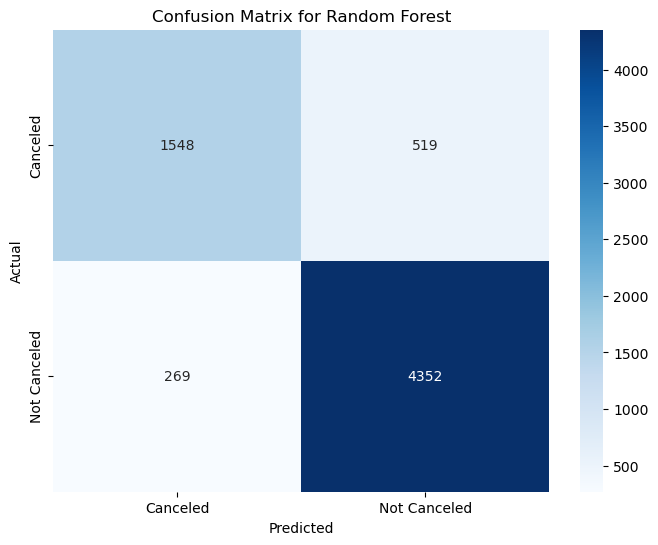

In [36]:
# visualization for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Canceled', 'Not Canceled'], yticklabels=['Canceled', 'Not Canceled'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()